In [2]:
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
from IPython.display import Image
from plotly.offline import init_notebook_mode
from scipy.stats import linregress
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import numpy as np

init_notebook_mode(connected=True)

<h3>Datagoons</h3>
<b>Members:</b>

Koen Hommels (14649365)

Ricky Speijker (14668971)

Poeyan Soud Alizadeh (14110830)

Silas Postma (14668599)

# Urbanization: a threat or opportunity?

*Have the browser set to fullscreen for the best results*

## Introduction


Urbanization is the process by which an increasing percentage of a population comes to live in urban areas. This transformative phenomenon is driven by various factors, including economic development, social changes, and technological advancements.
 As cities grow and evolve, they become hubs of innovation, culture, and opportunity, attracting people from rural areas in search of better employment, education, and lifestyle prospects. However, urbanization also brings challenges such as overcrowding, environmental degradation, and strain on infrastructure and public services. 
In this data story, we will explore two primary perspectives on urbanization:
Urbanization is good for a country and urbanization is bad for a country.

We will do this by exploring the following topics: Life Expectancy, Climate Change, Economic Growth, Education and Air Pollution.

## Preprocessing

To compare income categories and urban populations, datasets from the UN and Our World in Data were preprocessed by removing titles, converting European decimal notation, and pivoting data into usable tables. These datasets were then merged based on regional and country identifiers for analysis and/or for specific years. <br>

For quantizing data, qcut was used to ensure that we compare and analyze the data in a fair and unbiased manner.
Because of the fact that some years were not present in the datasets, we decided not to merge all of the datasets into one big dataset. This ensured that valuable data was not lost.<br>
Countries that have different spellings (e.g. United Stated vs United States Of America) were changed so that they were consistent and not lost during joining datasets.


## Argumentation

### Life expectancy

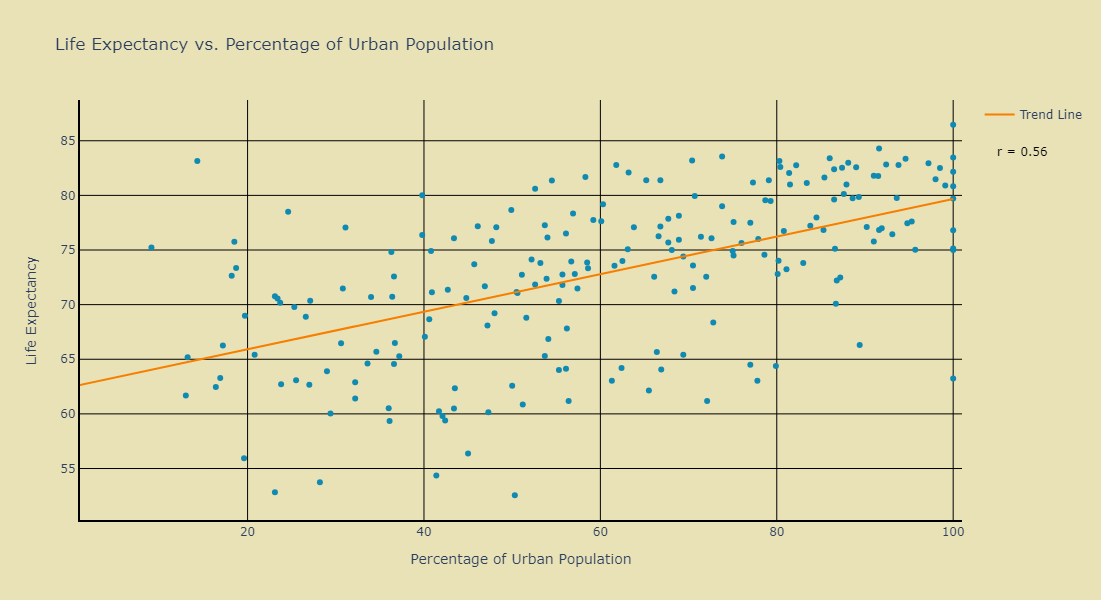

In [12]:
life_expectancy_df = pd.read_csv('life-expectancy.csv')
life_expectancy_2018 = life_expectancy_df[life_expectancy_df['Year'] == 2018]

urban_rural_df = pd.read_csv('CSV bestand - Data.csv', skiprows=1)

relevant_columns = ['Index', 'country', 'Index1', 'Index2', 'Index3', 'Rural', 'Total', 'Percentage_urban'] + ['Year_'+str(i) for i in range(1, urban_rural_df.shape[1]-7)]
urban_rural_df.columns = relevant_columns

merged_df = pd.merge(life_expectancy_2018, urban_rural_df, left_on='Entity', right_on='country', how='inner')

filtered_df = merged_df[['Entity', 'Percentage_urban', 'Life_expectancy']].copy()
filtered_df.dropna(inplace=True)
filtered_df['Percentage_urban'] = filtered_df['Percentage_urban'].str.replace(',', '.').astype(float)

slope, intercept, r_value, p_value, std_err = linregress(filtered_df['Percentage_urban'], filtered_df['Life_expectancy'])

fig = px.scatter(filtered_df, x='Percentage_urban', y='Life_expectancy', 
                 hover_data=['Entity'],  
                 title='Life Expectancy vs. Percentage of Urban Population',
                 labels={'Percentage_urban': 'Percentage of Urban Population', 
                         'Life_expectancy': 'Life Expectancy'},
                 color_discrete_sequence=['#118AB2'])

fig.add_trace(go.Scatter(x=filtered_df['Percentage_urban'], 
                         y=intercept + slope * filtered_df['Percentage_urban'], 
                         mode='lines', 
                         name='Trend Line',
                         line=dict(color='#F77F00')))

fig.update_layout(
    xaxis=dict(range=[1, 101]),
        width=800, 
    height=600, 
    plot_bgcolor='#eae2b7',
    paper_bgcolor='#eae2b7'
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='black')

fig.add_annotation(
    text=f'r = {r_value:.2f}',
    xref="paper", yref="paper",
    x=1.1, y=0.9, showarrow=False,
    font=dict(size=12, color="black"),
    align="left",
)
                   
fig.show()


We use the dataset on urbanization previously mentioned in this report. 
The variables used are the countries, excluding the first 16 entries in the dataset because those are continents or the world. 
Additionally, we use the urbanization percentage of each country in 2018. 
From the second dataset on life expectancy, we filtered the data to include only the year 2018 to ensure consistency with the other dataset. 
We then selected the variables for life expectancy and countries. 
We decided that a scatter plot would best visualize this relationship, so that is what we chose.

A scatter plot analysis of life expectancy versus the percentage of urban population in various countries 
reveals a positive correlation between the two variables. 
The plot, created using the two datasets in the year 2018, shows that as the percentage of a country's urban population increases, 
so does the life expectancy of its citizens.

Countries with high urbanization rates, such as Japan, Germany, and the United States, 
exhibit life expectancies that surpass 80 years. 
These countries benefit from advanced healthcare systems, widespread public health initiatives, 
and a higher standard of living, which are more prevalent in urban settings. 
But, countries with lower levels of urbanization often have shorter life expectancies, 
reflecting the challenges faced by rural areas, such as limited access to healthcare and lower economic development.


### Climate Change

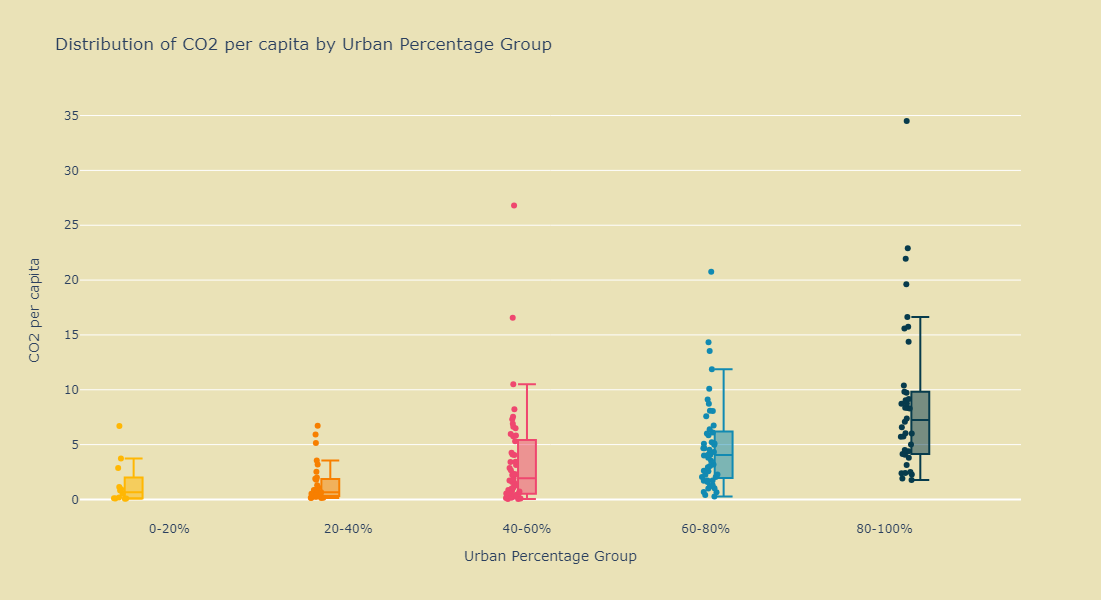

In [15]:

df = pd.read_csv('owid-co2-data.csv')
urban_percent_df = pd.read_csv('Urban.csv')

year = 2018
df_2018 = df[df['year'] == year]
df_2018 = df_2018[df_2018['iso_code'].notna()]
df_2018_sorted = df_2018.sort_values(by='co2_per_capita', ascending=False)

countries_2018 = df_2018_sorted['country'].unique()
urban_percent_df = urban_percent_df[urban_percent_df['Region, subregion, country or area'].isin(countries_2018)]

urban_percent_df['Percentage urban'] = urban_percent_df['Percentage urban'].str.replace(',', '.').astype(float)
urban_percent_df.dropna(subset=['Percentage urban'], inplace=True)
merged_df = pd.merge(df_2018_sorted, urban_percent_df, left_on='country', right_on='Region, subregion, country or area')
merged_df_sorted = merged_df.sort_values(by='Percentage urban', ascending=False)

bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
merged_df_sorted['Urban Group'] = pd.cut(merged_df_sorted['Percentage urban'], bins=bins, labels=labels, right=False)

data_to_plot = []
for label in labels:
    group_data = merged_df_sorted[merged_df_sorted['Urban Group'] == label]['co2_per_capita']
    if group_data.empty:
        data_to_plot.append(pd.Series([None]))
    else:
        data_to_plot.append(group_data)

colors = ['#FFB703', '#F77F00', '#EF476F', '#118AB2', '#073B4C']

fig = go.Figure()
for data, label, color in zip(data_to_plot, labels, colors):
    fig.add_trace(go.Box(y=data, name=label, boxpoints='all', jitter=1, whiskerwidth=1, marker_size=6, line_width=2,
                         hoverinfo='y+name', marker_color=color))

fig.update_layout(
    title='Distribution of CO2 per capita by Urban Percentage Group',
    xaxis_title='Urban Percentage Group',
    yaxis_title='CO2 per capita',
    showlegend=False,
    width=800,
    height=600,
    boxmode='group',
    boxgap=0.5,
    boxgroupgap=0,
    plot_bgcolor='#eae2b7',
    paper_bgcolor='#eae2b7'
)

fig.show()


Countries with higher levels of urbanization tend to contribute more to climate change, particularly through increased CO2 emissions. This is primarily due to several factors: Firstly, urban areas have higher energy demands for transportation, heating, cooling, and industry, often relying heavily on fossil fuels. Secondly, the concentration of vehicles and infrastructure in cities leads to more emissions from transportation. Additionally, urban centers often host significant industrial activities and manufacturing processes, which are energy-intensive and contribute to emissions. Despite potential efficiencies in resource use per capita, the density of people and activities in cities can amplify overall emissions. Lastly, the construction and maintenance of urban infrastructure further contribute to emissions if not designed sustainably. To show this is true we will be using this dataset:  'owid-co2-data.csv'.

### Economic Growth

An idea that many people share of less developed countries is that the population of those countries mainly live on farms, in smaller villages, etc. More wealthy countries seem to invest more in their cities; building skyscrapers, investing in universities, and creating large suburbs. This idea would favor the pro-urbanisation side of this debate. To put this to the test, the percentage of the population living in urban areas is compared to the GDP category. GDP stands for 'gross domestic product', and is an accessible way to compare the wealth of nations and regions. For this graph the countries have been split up into quartiles.

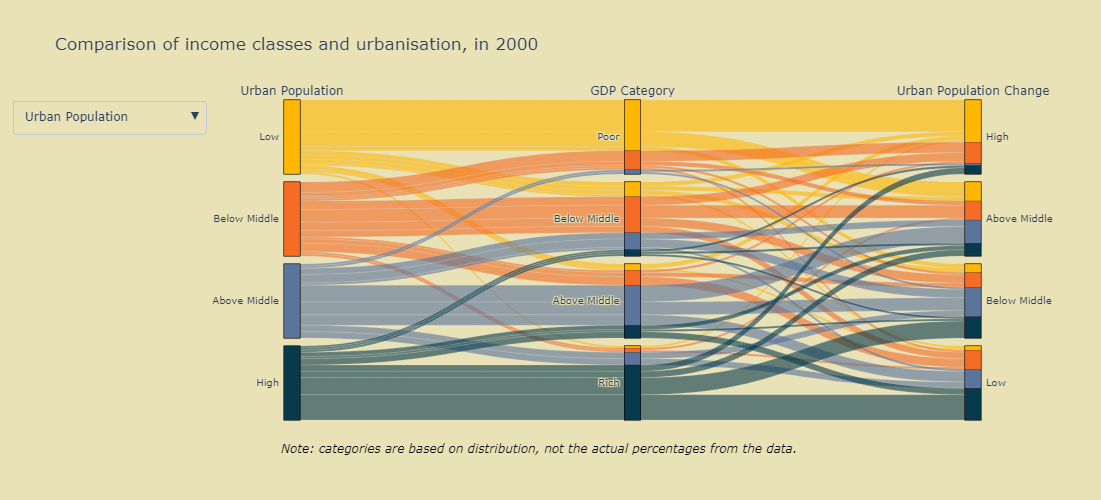

In [19]:
urban_percent_df = pd.read_csv('urban_data_percent.csv')
urban_percent_change_df = pd.read_csv('Urban_data_percent_change.csv')
gdp_df = pd.read_csv('pivoted_gdp_per_capita.csv')

merged_df = pd.merge(gdp_df, urban_percent_df, left_on='Entity', right_on='Region, subregion, country or area')
merged_df = pd.merge(merged_df, urban_percent_change_df, left_on='Entity', right_on='Region, subregion, country or area')

merged_df['2000_y'] = merged_df['2000_y'].str.replace(',', '.')
merged_df['2000_y'] = pd.to_numeric(merged_df['2000_y'], errors='coerce')

merged_df['2000-2005'] = merged_df['2000-2005'].str.replace(',', '.')
merged_df['2000-2005'] = pd.to_numeric(merged_df['2000-2005'], errors='coerce')

merged_df = merged_df.dropna(subset=['2000_x', '2000_y', '2000-2005']).copy()

merged_df['urban_pop_category'] = pd.qcut(merged_df['2000_y'], q=4, labels=['Low', 'Below Middle', 'Above Middle', 'High'])
merged_df['gdp_category'] = pd.qcut(merged_df['2000_x'], q=4, labels=['Poor', 'Below Middle', 'Above Middle', 'Rich'])
merged_df['urban_pop_category_change'] = pd.qcut(merged_df['2000-2005'], q=4, labels=['Low', 'Below Middle', 'Above Middle', 'High'])

color_palette = ['#FFB703', '#F77F00', '#EF476F', '#118AB2', '#073B4C']

colorscale = [[i / (len(color_palette) - 1), color] for i, color in enumerate(color_palette)]

gdp_category_counts = merged_df['gdp_category'].value_counts(normalize=True).sort_index()
urban_pop_category_counts = merged_df['urban_pop_category'].value_counts(normalize=True).sort_index()
urban_pop_category_change_counts = merged_df['urban_pop_category_change'].value_counts(normalize=True).sort_index(ascending=False)

gdp_category_sorted = gdp_category_counts.index.tolist()
urban_pop_category_sorted = urban_pop_category_counts.index.tolist()
urban_pop_category_change_sorted = urban_pop_category_change_counts.index.tolist()

fig1 = go.Figure(go.Parcats(
    dimensions=[
        {
            'label': 'Urban Population',
            'values': merged_df['urban_pop_category'],
            'categoryorder': 'array',
            'categoryarray': urban_pop_category_sorted
        },
        {
            'label': 'GDP Category',
            'values': merged_df['gdp_category'],
            'categoryorder': 'array',
            'categoryarray': gdp_category_sorted
        },
        {
            'label': 'Urban Population Change',
            'values': merged_df['urban_pop_category_change'],
            'categoryorder': 'array',
            'categoryarray': urban_pop_category_change_sorted
        },
    ],
    line={'color': merged_df['urban_pop_category'].cat.codes, 'colorscale': colorscale},
))

fig1.update_traces(line_shape='hspline', selector=dict(type='parcats'))
fig1.update_layout(title="Comparison of income classes and urbanisation, in 2000", height=500)

update_menus = [
    {
        'buttons': [
            {
                'label': 'Urban Population',
                'method': 'restyle',
                'args': [{'line.color': [merged_df['urban_pop_category'].cat.codes]}]
            },
            {
                'label': 'GDP Category',
                'method': 'restyle',
                'args': [{'line.color': [merged_df['gdp_category'].cat.codes]}]
            },
            {
                'label': 'Urban Population Change',
                'method': 'restyle',
                'args': [{'line.color': [merged_df['urban_pop_category_change'].cat.codes]}]
            }
        ],
        'direction': 'down',
        'showactive': True,
    }
]


fig1.update_layout(
    updatemenus=update_menus
)
fig1.add_annotation(dict(font=dict(color='black', size=12),
                         x=0.045,
                         y=-0.12,
                         showarrow=False,
                         text="<span style='font-style: italic;'>Note: categories are based on distribution, not the actual percentages from the data.</span>",
                         textangle=0,
                         xanchor='left',
                         xref="paper",
                         yref="paper"))
fig1.update_layout(
    title="Comparison of income classes and urbanisation, in 2000",
    height=500,
    plot_bgcolor='#eae2b7',
    paper_bgcolor='#eae2b7'
)

fig1.show()

After visualizing the data, it becomes apparent that the countries with a higher GDP make up most of the countries with the largest proportion of the population living in urban areas (see the graph with *'GDP Category'* or *'Urban Population'* enabled). To support the idea that urbanization leads to a higher GDP, it has to be believed that the correlation between the two is *caused* by the rising urbanization. This is argued in Glaeser, E. L., & Gottlieb, J. D. (2009). *"The Wealth of Cities: Agglomeration Economies and Spatial Equilibrium in the United States". Journal of Economic Literature, 47(4), 983-1028*. This paper supports the notion that urbanization drives economic growth by fostering environments where innovation and productivity can flourish. It emphasizes that cities, through agglomeration economies, become centers of economic activity that significantly contribute to higher GDP.

However, there are many other articles that contradict this idea. One of those papers builds a strong case supporting the idea that it is not urbanization that leads to economic growth, but in fact the other way around. Bloom, D. E., Canning, D., & Fink (2008) argue in their paper *"Urbanization and the Wealth of Nations"* that economic growth precedes urbanization, as higher GDP and economic opportunities in urban areas attract rural populations.

Lastly, in an attempt to out the direction of the causation, a third variable was added to the graph. This uncovers that less wealthy countries have a higher increase in population in rural areas. Assuming that the increase of GDP happens gradually, not instantly, it could be concluded that countries with lower GDP have more people migrating to urban areas. However, although the correlation is obvious, the causation between the variables is very dependent on interpretation.

### Education

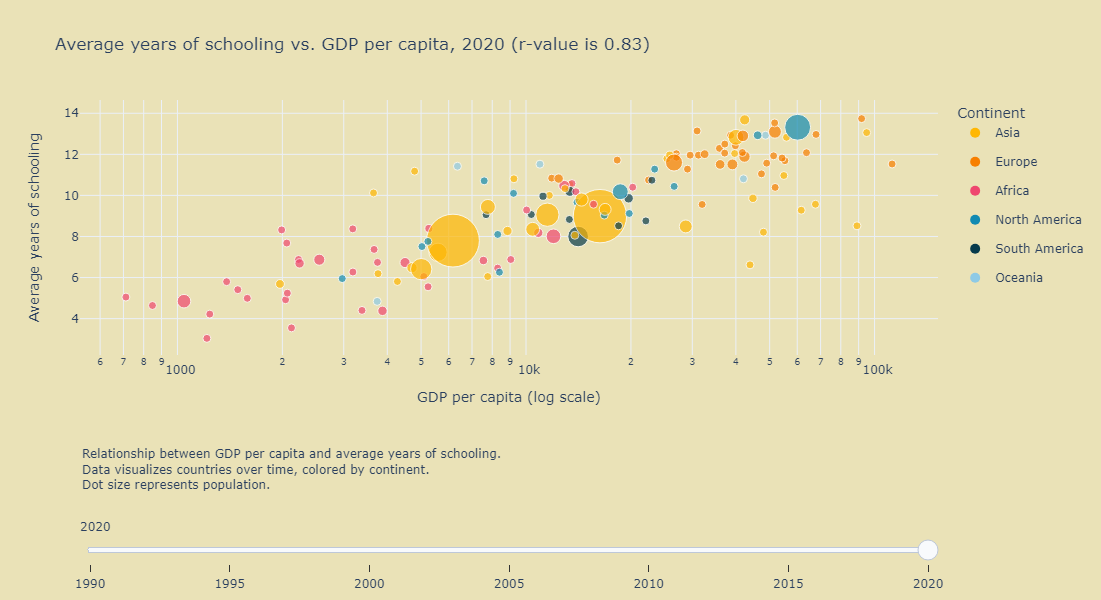

In [22]:
file_path = 'average-years-of-schooling-vs-gdp-per-capita.csv'
data = pd.read_csv(file_path)

data = data[data['Entity'] != 'World']

data_cleaned = data.dropna(subset=[
    'GDP per capita, PPP (constant 2017 international $)',
    'Combined - average years of education for 15-64 years male and female youth and adults',
    'Population (historical estimates)'
])

continent_info = data_cleaned[data_cleaned['Year'] == 2015][['Entity', 'Continent']].drop_duplicates()

data_cleaned = data_cleaned.merge(continent_info, on='Entity', how='left', suffixes=('', '_2015'))

continent_colors = {
    'Asia': '#FFB703',
    'Europe': '#F77F00',
    'Africa': '#EF476F',
    'North America': '#118AB2',
    'South America': '#073B4C',
    'Oceania': '#8ECAE6'
}

data_cleaned = data_cleaned.copy()
data_cleaned.loc[:, 'Color'] = data_cleaned['Continent_2015'].map(continent_colors)

years = sorted(data_cleaned['Year'].unique())

fig = make_subplots()

for year in years:
    yearly_data = data_cleaned[data_cleaned['Year'] == year]

    if len(yearly_data) > 1:
        r, _ = pearsonr(np.log10(yearly_data['GDP per capita, PPP (constant 2017 international $)']),
                        yearly_data['Combined - average years of education for 15-64 years male and female youth and adults'])
        r = round(r, 2)
    else:
        r = 'N/A'
    
    scatter = go.Scatter(
        x=yearly_data['GDP per capita, PPP (constant 2017 international $)'],
        y=yearly_data['Combined - average years of education for 15-64 years male and female youth and adults'],
        mode='markers',
        marker=dict(
            size=yearly_data['Population (historical estimates)'] / 1e6,
            sizemin=4,  # Set minimum size for visibility
            sizemode='area',
            color=yearly_data['Color'],
            showscale=False
        ),
        name=f'{year} (r={r})',
        text=yearly_data['Entity'],
        hovertemplate=(
            "<b>%{text}</b><br><br>"
            "GDP: %{x}<br>"
            "Years of schooling: %{y}<extra></extra>"
        ),
        visible=False,
        showlegend=False
    )
    fig.add_trace(scatter)

fig.data[-1].visible = True

for continent, color in continent_colors.items():
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        legendgroup=continent,
        showlegend=True,
        name=continent
    ))

description_text = (
    "Relationship between GDP per capita and average years of schooling.<br>"
    "Data visualizes countries over time, colored by continent.<br>"
    "Dot size represents population."
)
max_width = 800

fig.add_annotation(
    xref="paper", yref="paper",
    x=0, y=-0.35,
    xanchor='left',
    yanchor='top',
    align='left',
    showarrow=False,
    text=description_text,
    font=dict(size=12),
    width=max_width,
)

fig.update_layout(
    sliders=[{
        'steps': [{
            'method': 'update',
            'label': str(year),
            'args': [{'visible': [year == y for y in years] + [True]*len(continent_colors)},
                     {'title': f'Average years of schooling vs. GDP per capita, {year} (r-value is {fig.data[years.index(year)].name.split(" ")[-1][3:-1]})'}]  # Update the title here
        } for year in years],
        'transition': {'duration': 300},
        'x': 0,
        'y': -0.55, 
        'active': years.index(2020),
    }],
    xaxis=dict(
        title='GDP per capita (log scale)',
        type='log'
    ),
    yaxis_title='Average years of schooling',
    template='plotly_white',
    legend_title='Continent',
    height=600,
    title=f'Average years of schooling vs. GDP per capita, 2020 (r-value is {fig.data[years.index(2020)].name.split(" ")[-1][3:-1]})',  
    paper_bgcolor='#eae2b7',
    plot_bgcolor='#eae2b7'
)


fig.show()


In addition to examining urbanization, this graph explores the relationship between GDP per capita and average years of schooling across countries. The data from 2020 shows a strong positive correlation, with an r-value of 0.83. This suggests that wealthier nations tend to have populations with more years of education. Each dot represents a country, sized by population and coloured by continent.

When combined with the previous parcat graph, which highlighted that higher urbanization often corresponds with higher GDP, this bubble chart supports the argument that urbanization facilitates better education. As countries urbanize, economic growth follows, leading to increased investments in education. This is further evidenced by the strong correlation between GDP and average years of schooling.

Looking at data from 1990, with a similar strong correlation (r-value of 0.84), we can observe how the relationship between GDP and education has evolved over 30 years. This historical perspective shows that as nations urbanize and grow economically, their investment in education also increases. 

If we accept the argument from the parcat graph that urbanization drives GDP growth, then it follows that urbanization also promotes better education outcomes. Cities, with their concentrated resources and infrastructure, can offer more educational opportunities, fostering environments where learning can thrive. Thus, urbanization not only boosts economic prosperity but also enhances educational attainment, creating a virtuous cycle of development and growth.

### Air pollution
Typically, countries that have more urbanization have more cars and bigger industries. This naturally leads to more CO2 emissions, like we have seen in the ‘climate change’ section. This led us to ask the question how the countries are affected by these kinds of air pollution. The year of 2019 was investigated.


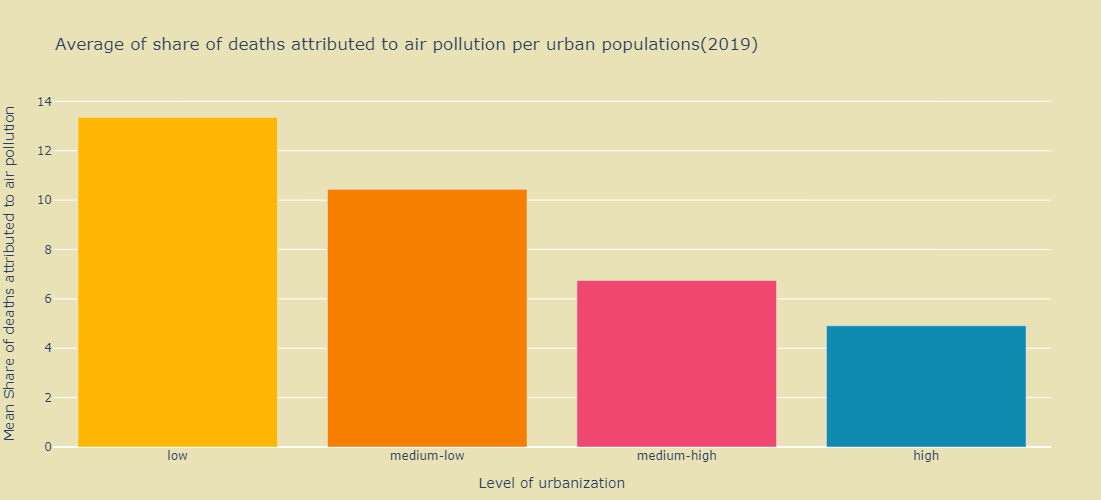

In [25]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("Urban2019.csv", decimal=',') 
df['2019_qcut'] = pd.qcut(df['2019'], q=4, labels=['low', 'medium-low', 'medium-high', 'high'])

df_airpollution = pd.read_csv("shareairpollutiondeaths.csv", decimal=',') 
df_airpollution = df_airpollution[df_airpollution['Year'] == 2019]

merged_df = pd.merge(df_airpollution, df, left_on='Entity', right_on='Region, subregion, country or area')
merged_df = merged_df.rename(columns={'2019': 'PercentageUrban'})
merged_df = merged_df.rename(columns={'Share of total deaths that are from all causes attributed to air pollution, in both sexes aged age-standardized': 'Share of deaths'})
merged_df.to_csv('merged1.csv', index=False)
merged_df = pd.read_csv("merged1.csv", decimal=',') 
merged_df['Share of deaths'] = merged_df['Share of deaths'].astype(float)

mean_low = merged_df[merged_df['2019_qcut'] == 'low']['Share of deaths'].mean()
mean_mediumlow = merged_df[merged_df['2019_qcut'] == 'medium-low']['Share of deaths'].mean()
mean_mediumhigh = merged_df[merged_df['2019_qcut'] == 'medium-high']['Share of deaths'].mean()
mean_high = merged_df[merged_df['2019_qcut'] == 'high']['Share of deaths'].mean()

means = [mean_low, mean_mediumlow, mean_mediumhigh, mean_high]
groups = ['low', 'medium-low', 'medium-high', 'high']
colors = ['#FFB703', '#F77F00', '#EF476F', '#118AB2']

fig = px.bar(x=groups, y=means, labels={'x':'Level of urbanization', 'y':'Mean Share of deaths attributed to air pollution'},
             color=groups, color_discrete_sequence=colors)

fig.update_layout(title='Average of share of deaths attributed to air pollution per urban populations(2019)')
fig.update_layout(
    margin=dict(l=50, r=50, t=100, b=50),
    height=500,
    width=800,
    paper_bgcolor='#eae2b7',
    plot_bgcolor='#eae2b7',
    showlegend=False
)

fig.show()


These results show that there is a trend. When split between four levels of urbanization, we can see that countries with the lowest level of urbanization have the highest average of share of deaths attributed to air pollution, while the countries with the highest level of urbanization have the lowest share of deaths. Correspondingly, in the section ‘life expectancy’, we saw that countries with high levels of urbanization have better life expactancies.

Proponents of urbanization can point out that urbanization will lead to fewer deaths. However, looking at this through the lens of quantiles will not tell the full story according to opponents of urbanization. Countries with less urbanization have a lesser GDP rate, which can account for the share of death.


### Deforestation

Urbanization rates consistently rise, driven by ongoing economic development and population growth. Deforestation rates, on the other hand, increase in a much more random and erratic manner. Despite this variability, deforestation has profound and far-reaching impacts. It leads to the destruction of vast tracts of forest, which serve as crucial habitats for countless species. The loss of these habitats results in the decline and often the extinction of many plant and animal species, significantly reducing biodiversity. This loss of biodiversity disrupts ecosystems, affecting everything from pollination to the stability of food chains.

In addition to habitat destruction, deforestation alters local climates and water cycles. Forests play a critical role in regulating temperatures and weather patterns through the process of evapotranspiration. When trees are removed, these regulatory processes are disrupted, leading to changes in local and regional climates, such as increased temperatures and altered rainfall patterns. These changes can have cascading effects on agriculture, water availability, and human livelihoods.

Furthermore, deforestation impacts soil health. Trees and vegetation protect the soil from erosion by wind and rain. When forests are cleared, the exposed soil is more susceptible to erosion, which can lead to the loss of fertile topsoil and decreased land productivity. This degradation of soil health affects agricultural outputs and can contribute to desertification in severe cases.


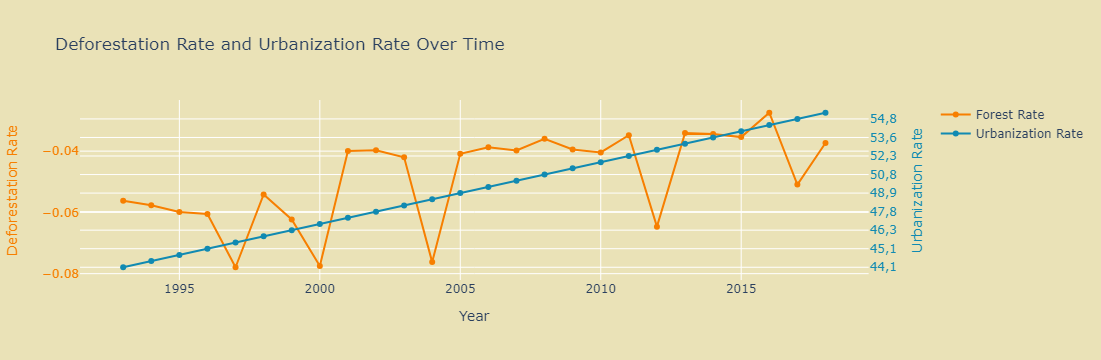

In [29]:
data = pd.read_csv('forest_area_decrease.csv')

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=data['Year'], 
        y=data['Forest_Rate'], 
        mode='lines+markers', 
        name='Forest Rate',
        line=dict(color='#F77F00'),
        marker=dict(color='#F77F00')
    ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(
        x=data['Year'], 
        y=data['Urbanization_Percentage'], 
        mode='lines+markers', 
        name='Urbanization Rate',
        line=dict(color='#118AB2'),
        marker=dict(color='#118AB2')
    ),
    secondary_y=True,
)

fig.update_layout(
    title='Deforestation Rate and Urbanization Rate Over Time',
    xaxis_title='Year',
    plot_bgcolor='#eae2b7',
    paper_bgcolor='#eae2b7'
)

fig.update_yaxes(
    title_text="Deforestation Rate", 
    secondary_y=False, 
    tickfont=dict(color='#F77F00'),
    titlefont=dict(color='#F77F00')
)
fig.update_yaxes(
    title_text="Urbanization Rate", 
    secondary_y=True, 
    tickfont=dict(color='#118AB2'),
    titlefont=dict(color='#118AB2')
)

fig.show()


## Summary

Our project explores the impact of urbanization by examining various aspects such as life expectancy, climate change, air pollution, GDP, average years of schooling vs GDP per capita and forest rate.  We found that urbanization generally has a positive impact on life expectancy due to better access to healthcare and improved living conditions in cities. <br>
However, it significantly contributes to climate change through increased greenhouse gas emissions and energy consumption, highlighting the environmental cost of growing cities. Urban areas often suffer from higher levels of air pollution due to industrial activities and transportation, negatively affecting public health. <br>
There is also a positive correlation between GDP and urbanization, indicating that economic growth tends to accompany urban expansion. Additionally, urbanization correlates with higher education levels, which in turn boosts GDP per capita. Urban areas typically offer better educational opportunities, leading to higher economic productivity. <br>
On the downside, urban expansion often leads to deforestation, reducing the forest rate over time. This trade-off underscores the environmental impact of urban growth. Lastly, the rate of urbanization has been steadily increasing, driven by population growth and economic development, reflecting the global shift towards more urbanized societies.


## Work Distribution

Our method of communication for this project involved two group chats: one dedicated to serious matters and the other for general questions and discussions of lesser importance. This setup allowed team members not actively participating in discussions to quickly and easily view conclusions. All our meetings took place on campus, we coordinated the time through the group chat.

During the first week, we determined our topic, arguments, and gathered datasets. By the second week, we had completed much of the work, including coding the graphs. The remaining weeks were spent refining our work, creating additional graphs, and finalizing the text.

We split up the arguments in 2 groups, we did this so we would still work together, but it would be too busy. Because working with 4 persons on one graph is not very effective. Koen and Ricky worked on deforestation, life expectancy and climate change. Silas and Poeyan worked on economic growth, Air pollution and education. In the end we all worked together to finish and smoothen out text.


## Incorporated Feedback

On June 20nd, 2024, our team K2 gathered with groups K1 and K3 for peer feedback, where one group at a time presented the work that had been done over the past three weeks. After each presentation, the other two groups provided feedback on what was done well and areas for improvement.
We received compliments for being quite advanced in our project and making good progress. <br>
Additionally, the TA was very positive overall.
Below is a list of the Peer Feedback:
- First graph: not really necessary.
- Second graph: calculate correlation. Draw a line to show the correlation. Include the coefficient if it is significant.
- Third graph: complete the boxplot.
- Parallel categories plot: very strong and relevant. This is one of the multivariate graphs.
  
We considered the feedback to be valuable and immediately began working on the Peer feedback points provided to further improve our project on the same day. Some of the graphs were completely redone, and some just had minor tweaks.

### Sources
- Glaeser, E. L., & Gottlieb, J. D. (2009). "The Wealth of Cities: Agglomeration Economies and Spatial Equilibrium in the United States". Journal of Economic Literature, 47(4), 983-1028.
- Bloom, D. E., Canning, D., & Fink, G. (2008). Urbanization and the Wealth of Nations. Science, 319(5864), 772-775.